In [1]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from evlp_bronch.dataset import ALL_LUNG_IDS, RawEVLPDataset, ProcessedEVLPDataset

In [2]:
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=0
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=0
)
# Splits result should be deterministic
assert set(val_lung_ids) == {8, 606}, str(val_lung_ids)
assert set(test_lung_ids) == {615, 731}, str(test_lung_ids)

train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)


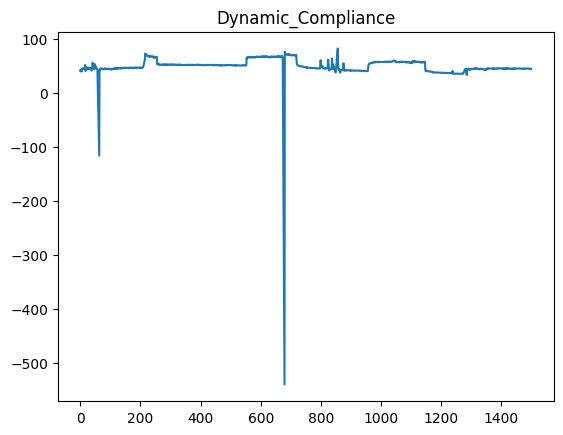

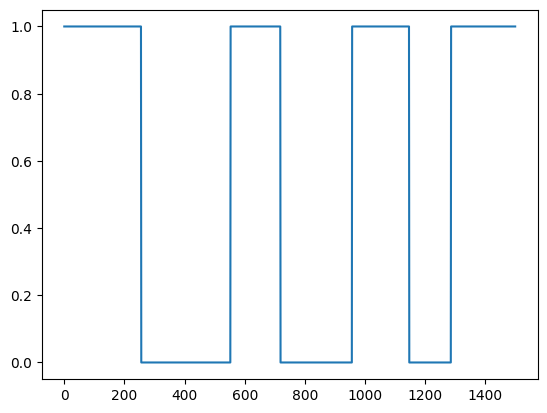

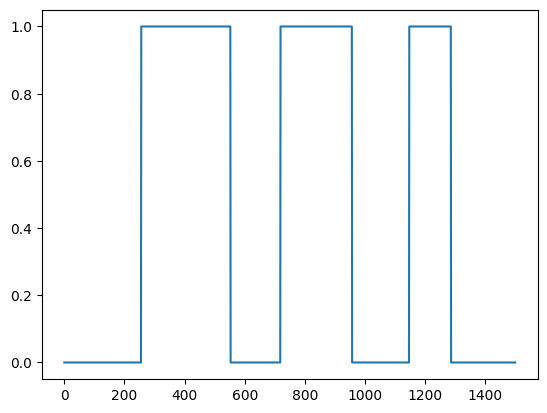

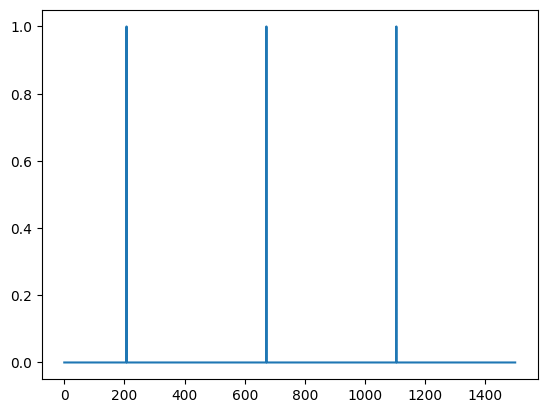

In [3]:
a = train_dataset[8]['Dy_comp']
c = train_dataset[8]['Is_normal']
b = train_dataset[8]['Is_assessment']
d = train_dataset[8]['Is_bronch']
plt.figure()
plt.title('Dynamic_Compliance')
plt.plot(a)
plt.figure()
plt.plot(c)
plt.figure()
plt.plot(b)
plt.figure()
plt.plot(d)

In [5]:
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D, Concatenate

In [6]:
def rindex(lst, value):
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [7]:
def center_pad_sequence(sequence, target_length):
        current_length = len(sequence)
        total_padding = target_length - current_length
        if total_padding <= 0:
            return sequence

        pad_before = total_padding // 2
        pad_after = total_padding - pad_before

        return np.pad(sequence, (pad_before, pad_after), mode='edge')
len(center_pad_sequence(train_dataset[0]['Is_bronch'][:1+1], 1470))

1470

In [8]:
X_dc = []
X_is_normal = []
X_is_bronch = []
X_is_assess = []

Y = []

for i in train_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1)
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0]
    last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    if metric_start > last_assessment_start:
        last_assessment_start = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0:
        continue

    X_dc.append(center_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal.append(center_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_assess.append(center_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_bronch.append(center_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y.append(center_pad_sequence(i['Dy_comp'][metric_start:last_assessment_start], 1054))
    
assert len(X_dc) == len(X_is_assess) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

In [9]:
X_dc = np.array(X_dc).reshape(-1, 1470, 1)
X_is_normal = np.array(X_is_normal).reshape(-1, 1470, 1)
X_is_bronch = np.array(X_is_bronch).reshape(-1, 1470, 1)
X_is_assess = np.array(X_is_assess).reshape(-1, 1470, 1)
Y = np.array(Y)

print(X_dc.shape)
print(X_is_normal.shape)
print(Y.shape)

(118, 1470, 1)
(118, 1470, 1)
(118, 1054)


In [10]:
input1 = Input(shape=(1470, 1))
cnn1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

input2 = Input(shape=(1470, 1))
cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu')(input2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

merge = Concatenate()([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1054, activation='linear')(dense)
model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X_dc, X_is_normal], Y, epochs=1000, verbose=0)

In [64]:
X_dc_val = []
X_label_val = []
Y_val = []
for i in val_dataset:
    if len(i['Dy_comp']) < 110:
        continue

    X_dc_val.append(i['Dy_comp'][-110:-10])
    X_label_val.append(i['Label'][-110:-10])
    Y_val.append(i['Dy_comp'][-10:])
X_dc_val = np.array(X_dc_val).reshape(-1, 100, 1)
X_label_val = np.array(X_label_val).reshape(-1, 100, 1)
Y_val = np.array(Y_val)

In [66]:
yhat = model.predict([X_dc_val, X_label_val], verbose=0)

In [70]:
def compute_loss(y, yhat):
    mse = np.mean((yhat - y) ** 2)
    rmse = np.sqrt(mse)
    return rmse
compute_loss(Y_val, yhat)

3.917117188599506